# Baseline Code for ANLP

## Table of content:
0. [Getting Started](#1.-Getting-Started)

Neil Fabiao

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/MyDrive/UniSussex/Baseline_code_Ngram'

/content/drive/MyDrive/UniSussex/Baseline_code_Ngram


In [3]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,random,math
from nltk import word_tokenize as tokenize
import pickle
import operator

nltk.download('punkt')#make sure you have all the necessary packages on colab

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 1 Getting started

In this notebook, you are going to be applying an n-gram language model to the Microsoft Research Sentence Completion Challenge (Zweig and Burges, 2011).

During the labs we developed an n-gram language model. 

## 1.1 importing language model from the previous lab

In [ ]:
def get_training_testing(training_dir,split=0.70):
    '''
    Initially we have a 50% split from the data.
    '''
    filenames=os.listdir(training_dir)
    n=len(filenames)
    print("There are {} files in the training directory: {}".format(n,training_dir))
    random.seed(53)  #if you want the same random split every time
    random.shuffle(filenames)
    index=int(n*split)
    trainingfiles=filenames[:index]
    heldoutfiles=filenames[index:]
    return trainingfiles,heldoutfiles


class language_model():
    
    def __init__(self,trainingdir,files=[]):
        self.training_dir=trainingdir
        self.files=files
        self.train()
        
    def train(self):    
        self.unigram={}
        self.bigram={}
        self.trigram={}
        #self.quadrigram={}
         
        self._processfiles_2()
        self._make_unknowns()
        self._discount()
        self._kneser_ney()
        self._convert_to_probs()
    
    def _processline(self,line):
        tokens=["__START"]+tokenize(line)+["__END"]
        previous="__END"
        previous_2="__END"
        trigrama = tuple([previous,previous_2]) #a tuple that holdes the values for our trigram

        for token in tokens:
            self.unigram[token]=self.unigram.get(token,0)+1

            current=self.bigram.get(previous,{})
            current[token]=current.get(token,0)+1

            #essentially trigrams are words going a group of 3 words. For bigrams we just use the previous word of unigram and assign to the bigram
            #basically the likely hood of 3 words going together. 
            #you need two previous words instead of just one

            
            current_trigram = self.trigram.get(trigrama,{})
            current_trigram[token]=current_trigram.get(token,0)+1

            self.bigram[previous]=current
            self.trigram[trigrama]=current_trigram

            previous_3 = previous_2
            previous_2 = previous
            previous=token
            
            trigrama = tuple([previous,previous_2]) #update the values such that we have w-2,w-1,wi
 
    def _processfiles(self):
        for afile in self.files:
            #print("Processing {}".format(afile))
            try:
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0:
                            self._processline(line)
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing {}: ignoring rest of file".format(afile))

    def _processfiles_2(self):
      for index,afile in enumerate(self.files):
          #print("Processing {}".format(afile))
          lines = " "
          if index%100==0:
            print("Processing at index number {}".format(index))
          try:
              with open(os.path.join(self.training_dir,afile)) as instream:
                  for line in instream:
                      lines+=(line)
                      #connan doyle is the author of The adventures of sherlock holves in the gutemberg dataset
                  if len(lines)>0 and re.search('conan doyle', lines, re.IGNORECASE):#use this if only training cherlock holmes books
                          self._processline(simple_cleaner(lines).rstrip())
          except UnicodeDecodeError:
              print("UnicodeDecodeError processing {}: ignoring rest of file".format(afile))
      
            
    def _convert_to_probs(self):
        
        self.unigram={k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
        self.bigram={key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
        self.kn={k:v/sum(self.kn.values()) for (k,v) in self.kn.items()}

        self.trigram = {key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.trigram.items()}
        self.kn_trigram = {k:v/sum(self.kn_trigram.values()) for (k,v) in self.kn_trigram.items()}

        ###adjust __UNK probabilities to include probability of an individual unknown word (1/number_unknowns)
        
        self.unigram["__UNK"]=self.unigram.get("__UNK",0)/self.number_unknowns
        self.bigram["__UNK"]={k:v/self.number_unknowns for (k,v) in self.bigram.get("__UNK",{}).items()}
        #self.trigram["__UNK"]={k:v/self.number_unknowns for (k,v) in self.trigram.get("__UNK",{}).items()}
        
        for key,adict in self.bigram.items():
            adict["__UNK"]=adict.get("__UNK",0)/self.number_unknowns
            self.bigram[key]=adict
        self.kn["__UNK"]=self.kn.get("__UNK",0)/self.number_unknowns
        
        for key,adict in self.trigram.items():
            adict["__UNK"]=adict.get("__UNK",0)/self.number_unknowns
            self.trigram[key]=adict
        self.kn_trigram["__UNK"]=self.kn_trigram.get("__UNK",0)/self.number_unknowns
        
    def get_prob(self,token,context="",methodparams={}):
      
        if methodparams.get("method","unigram")=="unigram":
            return self.unigram.get(token,self.unigram.get("__UNK",0))

        elif methodparams.get("method","bigram")=="bigram":
            if methodparams.get("smoothing","kneser-ney")=="kneser-ney":
                unidist=self.kn
            else:
                unidist=self.unigram
            bigram=self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
            big_p=bigram.get(token,bigram.get("__UNK",0))
            lmbda=bigram["__DISCOUNT"]
            uni_p=unidist.get(token,unidist.get("__UNK",0))
            #print(big_p,lmbda,uni_p)
            p=big_p+lmbda*uni_p            
            return p
        
        elif methodparams.get("method","trigram")=="trigram":
          if methodparams.get("smoothing","kneser-ney") == "kneser-ney":
            unidist = self.kn_trigram
            unidist_bigram = self.kn
          else:
            unidist_bigram = self.unigram

          if len(context) < 2:
            context = ["__END", context[0]]
          trigram=self.trigram.get(tuple(context[-2:]),self.trigram.get("__UNK",{}))
          trig_p=trigram.get(token,trigram.get("__UNK",0))
          lmbda_trigram = trigram["__DISCOUNT"]

          bigram=self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
          big_p=bigram.get(token,bigram.get("__UNK",0))
          lmbda_bigram = bigram["__DISCOUNT"]
          
          uni_p = unidist_bigram.get(token,unidist_bigram.get("__UNK",0))

          p = trig_p + (lmbda_trigram * big_p) + (lmbda_bigram * uni_p) 
          return p  
    
    def nextlikely(self,k=1,current="",method="unigram"):
        #use probabilities according to method to generate a likely next sequence
        #choose random token from k best
        blacklist=["__START","__UNK","__DISCOUNT"]
       
        if method=="unigram":
            dist=self.unigram
        else:
            dist=self.bigram.get(current,self.bigram.get("__UNK",{}))
    
        #sort the tokens by unigram probability
        mostlikely=sorted(list(dist.items()),key=operator.itemgetter(1),reverse=True)
        #filter out any undesirable tokens
        filtered=[w for (w,p) in mostlikely if w not in blacklist]
        #choose one randomly from the top k
        res=random.choice(filtered[:k])
        return res
    
    def generate(self,k=1,end="__END",limit=20,method="bigram",methodparams={}):
        if method=="":
            method=methodparams.get("method","bigram")
        current="__START"
        tokens=[]
        while current!=end and len(tokens)<limit:
            current=self.nextlikely(k=k,current=current,method=method)
            tokens.append(current)
        return " ".join(tokens[:-1])
    
    def compute_prob_line(self,line,methodparams={}):
        #this will add _start to the beginning of a line of text
        #compute the probability of the line according to the desired model
        #and returns probability together with number of tokens
        
        tokens=["__START"]+tokenize(line)+["__END"]
        acc=0
        for i,token in enumerate(tokens[1:]):
            acc+=math.log(self.get_prob(token,tokens[:i+1],methodparams))
        return acc,len(tokens[1:])
    
    def compute_probability(self,filenames=[],methodparams={}):
        #computes the probability (and length) of a corpus contained in filenames
        if filenames==[]:
            filenames=self.files
        
        total_p=0
        total_N=0
        for i,afile in enumerate(filenames):
            #print("Processing file {}:{}".format(i,afile))
            try:
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0 and re.search('conan doyle', lines, re.IGNORECASE) :
                            p,N=self.compute_prob_line(line,methodparams=methodparams)
                            total_p+=p
                            total_N+=N
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing file {}: ignoring rest of file".format(afile))
        return total_p,total_N
    
    def compute_perplexity(self,filenames=[],methodparams={"method":"bigram","smoothing":"kneser-ney"}):
        
        #compute the probability and length of the corpus
        #calculate perplexity
        #lower perplexity means that the model better explains the data
        
        p,N=self.compute_probability(filenames=filenames,methodparams=methodparams)
        #print(p,N)
        pp=math.exp(-p/N)
        return pp  
    
    def _make_unknowns(self,known=2):
        unknown=0
        self.number_unknowns=0

        #unigram
        for (k,v) in list(self.unigram.items()):
            if v<known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
                self.number_unknowns+=1
        
        #bigrams
        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
            else:
                self.bigram[k]=adict
        
        #trigrams
        for (key_,adict) in list(self.trigram.items()):
          for (kk,v) in list(adict.items()):
            isknown = self.unigram.get(kk,0)
            if isknown == 0 and not kk == "__DISCOUNT":
              adict["__UNK"] = adict.get("__UNK",0) + v
              del adict[kk]
          previous, previous_2 = key_
          isknown_1 = self.unigram.get(previous,0)
          isknown_2 = self.unigram.get(previous_2,0)
          if isknown_1 == 0 or isknown_2 == 0:
            del self.trigram[key_]
            current = self.trigram.get("__UNK",{})
            current.update(adict)
            self.trigram["__UNK"] = current
          else:
            self.trigram[k] = adict
                
    def _discount(self,discount=0.75):
        #discount each bigram count by a small fixed amount
        self.bigram={k:{kk:value-discount for (kk,value) in adict.items()}for (k,adict) in self.bigram.items()}

        # trigram discount
        self.trigram = {k:{kk:value-discount for (kk,value) in adict.items()}for (k,adict) in self.trigram.items()}
        
        #for each word, store the total amount of the discount so that the total is the same 
        #i.e., so we are reserving this as probability mass 
        for k in self.bigram.keys():
          lamb=len(self.bigram[k])
          self.bigram[k]["__DISCOUNT"]=lamb*discount

        for k in self.trigram.keys():
          lamb = len(self.trigram[k])
          self.trigram[k]["__DISCOUNT"] = lamb*discount
               
    def _kneser_ney(self):
        #work out kneser-ney unigram probabilities #Neil Fabiao
        #count the number of contexts each word has been seen in
        self.kn={}
        for (k,adict) in self.bigram.items():
            for kk in adict.keys():
                self.kn[kk]=self.kn.get(kk,0)+1

        self.kn_trigram = {}
        for (k,adict) in self.trigram.items():
          for kk in adict.keys():
            self.kn_trigram[kk] = self.kn_trigram.get(kk,0)+1
    

## 1.1.1 Testing and makig sure we can:
* look up bigram probabilities
* generatate a sentence according to the model
* calculate the perplexity of a test sentence

In [ ]:
#you may need to update this when running on your own machine 
parentdir= '../sentence-completion'
TRAINING_DIR=os.path.join(parentdir,"Holmes_Training_Data")
training,testing=get_training_testing(TRAINING_DIR)
mylm=language_model(trainingdir=TRAINING_DIR,files=training[:10])

There are 522 files in the training directory: ../sentence-completion/Holmes_Training_Data


In [ ]:
print('Looking up unigram probabilities')
print(mylm.generate(k=10,method='unigram'))

print('Generating sentence according to the model')
print(mylm.generate(method='unigram'))

print('Computing perplexity')
mylm.compute_perplexity(methodparams={"method":"unigram","smoothing":"kneser-ney"})

Looking up unigram probabilities
'' the the , `` and . , the to '' . of `` and , . . .
Generating sentence according to the model

Computing perplexity


638.2420476803173

In [ ]:
print('Looking up bigram probabilities')
print(mylm.generate(k=10,method='bigram'))

print('Generating sentence according to the model')
print(mylm.generate(method='bigram'))

print('Computing perplexity')
mylm.compute_perplexity(methodparams={"method":"bigram","smoothing":"kneser-ney"})

Looking up bigram probabilities
the king , I 've got the world , ' She looked upon me , I can . The
Generating sentence according to the model
`` I am not
Computing perplexity


98.51955775889262

In [ ]:
print('Looking up trigram probabilities')
print(mylm.generate(k=10,method='trigram'))

print('Generating sentence according to the model')
print(mylm.generate(method='trigram'))

print('Computing perplexity')
mylm.compute_perplexity(methodparams={"method":"trigram","smoothing":"kneser-ney"})

Looking up trigram probabilities
to see it ? And I
Generating sentence according to the model
`` I am not
Computing perplexity


129.60295441092222

## 1.2 Now lets load in and have a look at the sentence completion challenge questions.

In [ ]:
import pandas as pd, csv
questions=os.path.join(parentdir,"testing_data.csv")
answers=os.path.join(parentdir,"test_answer.csv")

with open(questions) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
qs_df=pd.DataFrame(lines[1:],columns=lines[0])
qs_df.head()

,id,question,a),b),c),d),e)
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus


## 1.3 Building and evaluating a system to carry out the Sentence Completion Challenge

In [ ]:
import csv

class question:
    
    def __init__(self,aline):
        self.fields=aline
    
    def get_field(self,field):
        return self.fields[question.colnames[field]]
    
    def add_answer(self,fields):
        self.answer=fields[1]
   
    def chooseA(self):
        return("a")

    def get_tokens(self):
      return ["__START"]+tokenize(self.fields[question.colnames["question"]])+["__END"]
    
    def get_left_context(self,window=1,target="_____"):
        '''
        if the current position has a blank point where you need to insert an answer. Then this code
        will look at the left hand side according to the window size and estimate the best probable word
        '''
        found=-1
        sent_tokens=self.get_tokens()
        for i,token in enumerate(sent_tokens):
          if token==target:
              found=i
              break  
            
        if found>-1:
            return sent_tokens[i-window:i]
        else:
            return []

    def get_right_context(self,window=1,target="_____"):
      '''
      if the current position has a blank point where you need to insert an answer. Then this code
      will look at the right hand side according to the window size and estimate the best probable word
      '''
      found=-1
      sent_tokens=self.get_tokens()
      for i,token in enumerate(sent_tokens):
        if token==target:
              found=i
              break  
        
      if found>-1:
          
          return sent_tokens[found+1:found+window+1]
          
      else:
          return []
        
    def predict_and_score(self,method):
        
        #compare prediction according to method with the correct answer
        #return 1 or 0 accordingly
        prediction=self.predict(method=method)
        if prediction ==self.answer:
            return 1
        else:
            return 0

    def choose(self,lm,method,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        
        #the tests are the n-grams which use both left and right context windows
        if method == "bigram" or method == "unigram" or method == "trigram":
          #this is a n-gram probability that uses both left and right context window
          rc=self.get_right_context(window=2)
          lc=self.get_left_context(window=2)
          #here is where you get the probability 
          probs=[lm.get_prob(rc[0],[self.get_field(ch+")")],methodparams={"method":method.split("_")[0]})
          *lm.get_prob(self.get_field(ch+")"),lc,methodparams={"method":method.split("_")[0]}) for ch in choices]

        elif method=="bigram_right" or method == "unigram_right" or method == "trigram_right":
          context=self.get_right_context(window=1)
          probs=[lm.get_prob(context[0],[self.get_field(ch+")")],methodparams={"method":method.split("_")[0]}) for ch in choices]
        
        #the normal bigram and unigram use only the left context
        elif method=="bigram_left" or method == "unigram_left" or method == "trigram_left":
          #this is the default method
          #if the method is just unigram it will go here
          #this is a n-gram probability that uses left context window
          context=self.get_left_context(window=2)
          #here is where you get the probability 
          probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]

        else:
          context=self.get_left_context(window=2)
          probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]

        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def predict(self,method="chooseA",model=mylm):
      if method=="chooseA":
          return self.chooseA()
      elif method=="random":
          return self.chooserandom()
      else:
          return self.choose(mylm,method=method)

class scc_reader:
    
    def __init__(self,qs,ans):
        self.qs=qs
        self.ans=ans
        self.read_files()
        
    def read_files(self):
        
        #read in the question file
        with open(self.qs) as instream:
            csvreader=csv.reader(instream)
            qlines=list(csvreader)
        
        #store the column names as a reverse index so they can be used to reference parts of the question
        question.colnames={item:i for i,item in enumerate(qlines[0])}
        
        #create a question instance for each line of the file (other than heading line)
        self.questions=[question(qline) for qline in qlines[1:]]
        
        #read in the answer file
        with open(self.ans) as instream:
            csvreader=csv.reader(instream)
            alines=list(csvreader)
            
        #add answers to questions so predictions can be checked    
        for q,aline in zip(self.questions,alines[1:]):
            q.add_answer(aline)
        
    def get_field(self,field):
        return [q.get_field(field) for q in self.questions] 
    
    def predict(self,method):
        return [q.predict(method=method) for q in self.questions]
    
    def predict_and_score(self,method):
        scores=[q.predict_and_score(method=method) for q in self.questions]
        return sum(scores)/len(scores)
    

## 1.3.1 Testing and makig sure we can:
* predict the score given by our model

In [ ]:
SCC = scc_reader(qs=questions,ans=answers)
#since bigrams and unigrams are probability based models. It is best to score the average of 10 - 20 runs depending on the speed.
#here I am just running the model and verifying that it works.
print('This is the score using unigrams:',SCC.predict_and_score(method="unigram"))
print('This is the score using bigrams:',SCC.predict_and_score(method="bigram"))
print('This is the score using trigrams:',SCC.predict_and_score(method="trigram"))

This is the score using unigrams: 0.25384615384615383
This is the score using bigrams: 0.2528846153846154
This is the score using trigrams: 0.2519230769230769


In [ ]:
print('This is the score using unigram testing:',SCC.predict_and_score(method="unigram_right"))
print('This is the score using bigrams testing:',SCC.predict_and_score(method="bigram_right"))
print('This is the score using trigrams testing:',SCC.predict_and_score(method="trigram_right"))

This is the score using unigram testing: 0.1875
This is the score using bigrams testing: 0.18461538461538463
This is the score using trigrams testing: 0.1798076923076923


In [ ]:
print('This is the score using unigram testing:',SCC.predict_and_score(method="unigram_"))
print('This is the score using bigrams testing:',SCC.predict_and_score(method="bigram_"))
print('This is the score using trigrams testing:',SCC.predict_and_score(method="trigram_"))

This is the score using unigram testing: 0.2778846153846154
This is the score using bigrams testing: 0.27307692307692305
This is the score using trigrams testing: 0.27692307692307694


In [ ]:
print('This is the prediction')
qs_df["unigram_pred"]=SCC.predict(method="unigram")
qs_df["bigram_pred"]=SCC.predict(method="bigram")
qs_df["trigram_pred"]=SCC.predict(method="trigram")
qs_df

This is the prediction


,id,question,a),b),c),d),e),unigram_pred,bigram_pred,trigram_pred
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking,e,a,a
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably,d,d,d
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance,d,d,a
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying,c,e,e
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus,c,c,c
...,...,...,...,...,...,...,...,...,...,...
1035,1036,The bedrooms in this _____ are on the ground f...,wing,coach,balcony,kingdom,neighbourhood,a,a,a
1036,1037,Our visitor bore every mark of being an averag...,blind,energetic,eloquent,pompous,sandy-haired,a,b,b
1037,1038,"The terror of his face lay in his eyes , howev...",cruelty,novitiate,justice,broker,success,e,c,c
1038,1039,"It is your commonplace , _____ crimes which ar...",underlying,featureless,theological,flattering,inevitable,e,e,e


### 2 Experimental setup 

#### 2.1 Experiment with different len of files 

In [ ]:
TRAINING_DIR=os.path.join(parentdir,"Holmes_Training_Data")

length_of_file = []
length_of_file = np.append(length_of_file, 5)#we want to start at 5 
length_of_file = np.append(length_of_file, 10)#we want to add 10 
length_of_file = np.append(length_of_file,np.arange(50, 250, 25)) #Create a sequence of numbers from 50 to 552
split_size = np.arange(0.0, 1.0, 0.1) #this is for later testing on split size.
#length_of_file = np.append(length_of_file, 200)
length_of_file = length_of_file.astype(int) #the array elemetns must be int

training,testing=get_training_testing(TRAINING_DIR,0.7)
print('In this experiment we have the following setup:')
print(length_of_file)

name_1 ='Sentence_Completion vanilla_unigram_5_225'
name_2 ='Sentence_Completion vanilla_bigram_5_225'
name_3 ='Sentence_Completion vanilla_trigram_5_225'
results_unigram = {}
results_bigram = {}
results_trigram = {}
number_of_runs = 3

There are 522 files in the training directory: ../sentence-completion/Holmes_Training_Data
In this experiment we have the following setup:
[  5  10  50  75 100 125 150 175 200 225]


In [ ]:
#sentence completion vanilla is the first step to understand the best length of file.
runs = 0

#for size in length_of_file:
for size in length_of_file:
    res_unigram = {}
    res_bigram = {}
    res_trigram = {}

    print("Processing file of length {}".format(size))

    for i in range(number_of_runs):
    
        mylm=language_model(trainingdir=TRAINING_DIR,files=training[:size])#loading the data from the files

        SCC = scc_reader(qs=questions,ans=answers)#computing the questions and answers given by the model

        accuracy_1 = SCC.predict_and_score(method="unigram_")
        accuracy_2 = SCC.predict_and_score(method="bigram_")
        accuracy_3 = SCC.predict_and_score(method="trigram_")

        res_unigram[name_1]=res_unigram.get(name_1,0)+accuracy_1/number_of_runs
        res_bigram[name_2]=res_bigram.get(name_2,0)+accuracy_2/number_of_runs
        res_trigram[name_3]=res_trigram.get(name_3,0)+accuracy_3/number_of_runs
        print('finished run',runs)
        runs+=1
        
    #computing perplexity for each n-gram
    perplexity_1 = mylm.compute_perplexity(methodparams={"method":"unigram","smoothing":"kneser-ney"})
    perplexity_2 = mylm.compute_perplexity(methodparams={"method":"bigram","smoothing":"kneser-ney"})
    perplexity_3 = mylm.compute_perplexity(methodparams={"method":"trigram","smoothing":"kneser-ney"})

    results_unigram[size]=[res_unigram,perplexity_1]
    results_bigram[size]=[res_bigram,perplexity_2]
    results_trigram[size]=[res_trigram,perplexity_3]
    
    
    #open a file, where you ant to store the data
    # opening and dump information to file
    with open('Sentence_Completion_vanilla_unigram_file_len225.pickle', 'wb') as f:
        pickle.dump(results_unigram, f)
        
    with open('Sentence_Completion_vanilla_bigram_file_len225.pickle', 'wb') as f:
        pickle.dump(results_bigram, f)
    
    with open('Sentence_Completion_vanilla_trigram_file_len225.pickle', 'wb') as f:
        pickle.dump(results_trigram, f)

    runs=0
    

Processing file of length 5
finished run 0
finished run 1
finished run 2
Processing file of length 10
finished run 0
finished run 1
finished run 2
Processing file of length 50
finished run 0
finished run 1
finished run 2
Processing file of length 75
finished run 0
finished run 1
finished run 2
Processing file of length 100
finished run 0
finished run 1
finished run 2
Processing file of length 125
finished run 0
finished run 1
finished run 2
Processing file of length 150
finished run 0
finished run 1
finished run 2
Processing file of length 175
UnicodeDecodeError processing WTSLW10.TXT: ignoring rest of file
finished run 0
UnicodeDecodeError processing WTSLW10.TXT: ignoring rest of file
finished run 1
UnicodeDecodeError processing WTSLW10.TXT: ignoring rest of file
finished run 2
UnicodeDecodeError processing file WTSLW10.TXT: ignoring rest of file
UnicodeDecodeError processing file WTSLW10.TXT: ignoring rest of file
UnicodeDecodeError processing file WTSLW10.TXT: ignoring rest of file


### 2.1 Experiment with context windows size 1

In [ ]:
class question(question):
    #you wouldn't normally have a class inherit from itself like this
    #but it is quite a neat way in jupyter notebooks to extend pre-existing classes
    #you could alternatively redefine the class (copying all of the pre-existing class)

    def choose(self,lm,method,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        
        #the tests are the n-grams which use both left and right context windows
        if method == "bigram" or method == "unigram" or method == "trigram":
          #this is a n-gram probability that uses both left and right context window
          rc=self.get_right_context(window=1)
          lc=self.get_left_context(window=1)
          #here is where you get the probability 
          probs=[lm.get_prob(rc[0],[self.get_field(ch+")")],methodparams={"method":method.split("_")[0]})
          *lm.get_prob(self.get_field(ch+")"),lc,methodparams={"method":method.split("_")[0]}) for ch in choices]

        elif method=="bigram_right" or method == "unigram_right" or method == "trigram_right":
            context=self.get_right_context(window=1)
            probs=[lm.get_prob(context[0],[self.get_field(ch+")")],methodparams={"method":method.split("_")[0]}) for ch in choices]
        
        #the normal bigram and unigram use only the left context
        elif method=="bigram_left" or method == "unigram_left" or method == "trigram_left":
          #this is the default method
          #if the method is just unigram it will go here
          #this is a n-gram probability that uses left context window
          context=self.get_left_context(window=1)
          #here is where you get the probability 
          probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]

        else:
            context=self.get_left_context(window=1)
            probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]

        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

In [ ]:
results_unigram = {}
results_bigram = {}
results_trigram = {}

name_1 ='Sentence_Completion vanilla_unigram_rightW2_100'
name_2 ='Sentence_Completion vanilla_bigram_rightW2_100'
name_3 ='Sentence_Completion vanilla_trigram_rightW2_100'
number_of_runs=3

#sentence completion vanilla is the first step to understand the best length of file.
runs = 0
size = 100

print("Processing file of length {}".format(size))

for i in range(number_of_runs):

    mylm=language_model(trainingdir=TRAINING_DIR,files=training[:size])#loading the data from the files

    SCC = scc_reader(qs=questions,ans=answers)#computing the questions and answers given by the model

    accuracy_1 = SCC.predict_and_score(method="unigram_right")
    accuracy_2 = SCC.predict_and_score(method="bigram_right")
    accuracy_3 = SCC.predict_and_score(method="trigram_right")

    res_unigram[name_1]=res_unigram.get(name_1,0)+accuracy_1/number_of_runs
    res_bigram[name_2]=res_bigram.get(name_2,0)+accuracy_2/number_of_runs
    res_trigram[name_3]=res_trigram.get(name_3,0)+accuracy_3/number_of_runs
    print('finished run',runs)
    runs+=1
    
#computing perplexity for each n-gram
perplexity_1 = mylm.compute_perplexity(methodparams={"method":"unigram","smoothing":"kneser-ney"})
perplexity_2 = mylm.compute_perplexity(methodparams={"method":"bigram","smoothing":"kneser-ney"})
perplexity_3 = mylm.compute_perplexity(methodparams={"method":"trigram","smoothing":"kneser-ney"})

results_unigram[size]=[res_unigram,perplexity_1]
results_bigram[size]=[res_bigram,perplexity_2]
results_trigram[size]=[res_trigram,perplexity_3]

#open a file, where you ant to store the data
# opening and dump information to file
with open('Sentence_Completion_vanilla_unigram_right_rightW2_100.pickle', 'wb') as f:
    pickle.dump(results_unigram, f)
    
with open('Sentence_Completion_vanilla_bigram_right_rightW2_100.pickle', 'wb') as f:
    pickle.dump(results_bigram, f)

with open('Sentence_Completion_vanilla_trigram_right_rightW2_100.pickle', 'wb') as f:
    pickle.dump(results_trigram, f)

runs=0

Processing file of length 100
finished run 0
finished run 1
finished run 2


In [ ]:
results_unigram = {}
results_bigram = {}
results_trigram = {}

name_1 ='Sentence_Completion vanilla_unigram_leftW2_100'
name_2 ='Sentence_Completion vanilla_bigram_leftW2_100'
name_3 ='Sentence_Completion vanilla_trigram_leftW2_100'
number_of_runs=3

#sentence completion vanilla is the first step to understand the best length of file.
runs = 0
size = 100

print("Processing file of length {}".format(size))

for i in range(number_of_runs):

    mylm=language_model(trainingdir=TRAINING_DIR,files=training[:size])#loading the data from the files

    SCC = scc_reader(qs=questions,ans=answers)#computing the questions and answers given by the model

    accuracy_1 = SCC.predict_and_score(method="unigram_left")
    accuracy_2 = SCC.predict_and_score(method="bigram_left")
    accuracy_3 = SCC.predict_and_score(method="trigram_left")

    res_unigram[name_1]=res_unigram.get(name_1,0)+accuracy_1/number_of_runs
    res_bigram[name_2]=res_bigram.get(name_2,0)+accuracy_2/number_of_runs
    res_trigram[name_3]=res_trigram.get(name_3,0)+accuracy_3/number_of_runs
    print('finished run',runs)
    runs+=1
    
#computing perplexity for each n-gram
perplexity_1 = mylm.compute_perplexity(methodparams={"method":"unigram","smoothing":"kneser-ney"})
perplexity_2 = mylm.compute_perplexity(methodparams={"method":"bigram","smoothing":"kneser-ney"})
perplexity_3 = mylm.compute_perplexity(methodparams={"method":"trigram","smoothing":"kneser-ney"})

results_unigram[size]=[res_unigram,perplexity_1]
results_bigram[size]=[res_bigram,perplexity_2]
results_trigram[size]=[res_trigram,perplexity_3]

#open a file, where you ant to store the data
# opening and dump information to file
with open('Sentence_Completion_vanilla_unigram_right_leftW2_100.pickle', 'wb') as f:
    pickle.dump(results_unigram, f)
    
with open('Sentence_Completion_vanilla_bigram_right_leftW2_100.pickle', 'wb') as f:
    pickle.dump(results_bigram, f)

with open('Sentence_Completion_vanilla_trigram_right_leftW2_100.pickle', 'wb') as f:
    pickle.dump(results_trigram, f)

runs=0

Processing file of length 100
finished run 0
finished run 1
finished run 2


In [ ]:
results_unigram = {}
results_bigram = {}
results_trigram = {}

name_1 ='Sentence_Completion vanilla_unigram_NormaltW2_100'
name_2 ='Sentence_Completion vanilla_bigram_NormalW2_100'
name_3 ='Sentence_Completion vanilla_trigram_NormalW2_100'
number_of_runs=3

#sentence completion vanilla is the first step to understand the best length of file.
runs = 0
size = 100

print("Processing file of length {}".format(size))

for i in range(number_of_runs):

    mylm=language_model(trainingdir=TRAINING_DIR,files=training[:size])#loading the data from the files

    SCC = scc_reader(qs=questions,ans=answers)#computing the questions and answers given by the model

    accuracy_1 = SCC.predict_and_score(method="unigram")
    accuracy_2 = SCC.predict_and_score(method="bigram")
    accuracy_3 = SCC.predict_and_score(method="trigram")

    res_unigram[name_1]=res_unigram.get(name_1,0)+accuracy_1/number_of_runs
    res_bigram[name_2]=res_bigram.get(name_2,0)+accuracy_2/number_of_runs
    res_trigram[name_3]=res_trigram.get(name_3,0)+accuracy_3/number_of_runs
    print('finished run',runs)
    runs+=1
    
#computing perplexity for each n-gram
perplexity_1 = mylm.compute_perplexity(methodparams={"method":"unigram","smoothing":"kneser-ney"})
perplexity_2 = mylm.compute_perplexity(methodparams={"method":"bigram","smoothing":"kneser-ney"})
perplexity_3 = mylm.compute_perplexity(methodparams={"method":"trigram","smoothing":"kneser-ney"})

results_unigram[size]=[res_unigram,perplexity_1]
results_bigram[size]=[res_bigram,perplexity_2]
results_trigram[size]=[res_trigram,perplexity_3]

#open a file, where you ant to store the data
# opening and dump information to file
with open('Sentence_Completion_vanilla_unigram_right_NormalW2_100.pickle', 'wb') as f:
    pickle.dump(results_unigram, f)
    
with open('Sentence_Completion_vanilla_bigram_right_NormalW2_100.pickle', 'wb') as f:
    pickle.dump(results_bigram, f)

with open('Sentence_Completion_vanilla_trigram_right_NormalW2_100.pickle', 'wb') as f:
    pickle.dump(results_trigram, f)

runs=0

Processing file of length 100
finished run 0
finished run 1
finished run 2


### 2.2 Experiment with context windows size 3

In [ ]:
class question(question):
    #you wouldn't normally have a class inherit from itself like this
    #but it is quite a neat way in jupyter notebooks to extend pre-existing classes
    #you could alternatively redefine the class (copying all of the pre-existing class)

    def choose(self,lm,method,choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        
        #the tests are the n-grams which use both left and right context windows
        if method == "bigram" or method == "unigram" or method == "trigram":
          #this is a n-gram probability that uses both left and right context window
          rc=self.get_right_context(window=3)
          lc=self.get_left_context(window=3)
          #here is where you get the probability 
          probs=[lm.get_prob(rc[0],[self.get_field(ch+")")],methodparams={"method":method.split("_")[0]})
          *lm.get_prob(self.get_field(ch+")"),lc,methodparams={"method":method.split("_")[0]}) for ch in choices]

        elif method=="bigram_right" or method == "unigram_right" or method == "trigram_right":
            context=self.get_right_context(window=3)
            probs=[lm.get_prob(context[0],[self.get_field(ch+")")],methodparams={"method":method.split("_")[0]}) for ch in choices]
        
        #the normal bigram and unigram use only the left context
        elif method=="bigram_left" or method == "unigram_left" or method == "trigram_left":
          #this is the default method
          #if the method is just unigram it will go here
          #this is a n-gram probability that uses left context window
          context=self.get_left_context(window=3)
          #here is where you get the probability 
          probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]

        else:
            context=self.get_left_context(window=3)
            probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]

        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)

In [ ]:
results_unigram = {}
results_bigram = {}
results_trigram = {}

name_1 ='Sentence_Completion vanilla_unigram_rightW3_100'
name_2 ='Sentence_Completion vanilla_bigram_rightW3_100'
name_3 ='Sentence_Completion vanilla_trigram_rightW3_100'
number_of_runs=3

#sentence completion vanilla is the first step to understand the best length of file.
runs = 0
size = 100

print("Processing file of length {}".format(size))

for i in range(number_of_runs):

    mylm=language_model(trainingdir=TRAINING_DIR,files=training[:size])#loading the data from the files

    SCC = scc_reader(qs=questions,ans=answers)#computing the questions and answers given by the model

    accuracy_1 = SCC.predict_and_score(method="unigram_right")
    accuracy_2 = SCC.predict_and_score(method="bigram_right")
    accuracy_3 = SCC.predict_and_score(method="trigram_right")

    res_unigram[name_1]=res_unigram.get(name_1,0)+accuracy_1/number_of_runs
    res_bigram[name_2]=res_bigram.get(name_2,0)+accuracy_2/number_of_runs
    res_trigram[name_3]=res_trigram.get(name_3,0)+accuracy_3/number_of_runs
    print('finished run',runs)
    runs+=1
    
#computing perplexity for each n-gram
perplexity_1 = mylm.compute_perplexity(methodparams={"method":"unigram","smoothing":"kneser-ney"})
perplexity_2 = mylm.compute_perplexity(methodparams={"method":"bigram","smoothing":"kneser-ney"})
perplexity_3 = mylm.compute_perplexity(methodparams={"method":"trigram","smoothing":"kneser-ney"})

results_unigram[size]=[res_unigram,perplexity_1]
results_bigram[size]=[res_bigram,perplexity_2]
results_trigram[size]=[res_trigram,perplexity_3]

#open a file, where you ant to store the data
# opening and dump information to file
with open('Sentence_Completion_vanilla_unigram_right_rightW3_100.pickle', 'wb') as f:
    pickle.dump(results_unigram, f)
    
with open('Sentence_Completion_vanilla_bigram_right_rightW3_100.pickle', 'wb') as f:
    pickle.dump(results_bigram, f)

with open('Sentence_Completion_vanilla_trigram_right_rightW3_100.pickle', 'wb') as f:
    pickle.dump(results_trigram, f)

runs=0

Processing file of length 100
finished run 0
finished run 1
finished run 2


In [ ]:
results_unigram = {}
results_bigram = {}
results_trigram = {}

name_1 ='Sentence_Completion vanilla_unigram_leftW3_100'
name_2 ='Sentence_Completion vanilla_bigram_leftW3_100'
name_3 ='Sentence_Completion vanilla_trigram_leftW3_100'
number_of_runs=3

#sentence completion vanilla is the first step to understand the best length of file.
runs = 0
size = 100

print("Processing file of length {}".format(size))

for i in range(number_of_runs):

    mylm=language_model(trainingdir=TRAINING_DIR,files=training[:size])#loading the data from the files

    SCC = scc_reader(qs=questions,ans=answers)#computing the questions and answers given by the model

    accuracy_1 = SCC.predict_and_score(method="unigram_left")
    accuracy_2 = SCC.predict_and_score(method="bigram_left")
    accuracy_3 = SCC.predict_and_score(method="trigram_left")

    res_unigram[name_1]=res_unigram.get(name_1,0)+accuracy_1/number_of_runs
    res_bigram[name_2]=res_bigram.get(name_2,0)+accuracy_2/number_of_runs
    res_trigram[name_3]=res_trigram.get(name_3,0)+accuracy_3/number_of_runs
    print('finished run',runs)
    runs+=1
    
#computing perplexity for each n-gram
perplexity_1 = mylm.compute_perplexity(methodparams={"method":"unigram","smoothing":"kneser-ney"})
perplexity_2 = mylm.compute_perplexity(methodparams={"method":"bigram","smoothing":"kneser-ney"})
perplexity_3 = mylm.compute_perplexity(methodparams={"method":"trigram","smoothing":"kneser-ney"})

results_unigram[size]=[res_unigram,perplexity_1]
results_bigram[size]=[res_bigram,perplexity_2]
results_trigram[size]=[res_trigram,perplexity_3]

#open a file, where you ant to store the data
# opening and dump information to file
with open('Sentence_Completion_vanilla_unigram_right_leftW3_100.pickle', 'wb') as f:
    pickle.dump(results_unigram, f)
    
with open('Sentence_Completion_vanilla_bigram_right_leftW3_100.pickle', 'wb') as f:
    pickle.dump(results_bigram, f)

with open('Sentence_Completion_vanilla_trigram_right_leftW3_100.pickle', 'wb') as f:
    pickle.dump(results_trigram, f)

runs=0

Processing file of length 100
finished run 0
finished run 1
finished run 2


In [ ]:
results_unigram = {}
results_bigram = {}
results_trigram = {}

name_1 ='Sentence_Completion vanilla_unigram_NormaltW3_100'
name_2 ='Sentence_Completion vanilla_bigram_NormalW3_100'
name_3 ='Sentence_Completion vanilla_trigram_NormalW3_100'
number_of_runs=3

#sentence completion vanilla is the first step to understand the best length of file.
runs = 0
size = 100

print("Processing file of length {}".format(size))

for i in range(number_of_runs):

    mylm=language_model(trainingdir=TRAINING_DIR,files=training[:size])#loading the data from the files

    SCC = scc_reader(qs=questions,ans=answers)#computing the questions and answers given by the model

    accuracy_1 = SCC.predict_and_score(method="unigram")
    accuracy_2 = SCC.predict_and_score(method="bigram")
    accuracy_3 = SCC.predict_and_score(method="trigram")

    res_unigram[name_1]=res_unigram.get(name_1,0)+accuracy_1/number_of_runs
    res_bigram[name_2]=res_bigram.get(name_2,0)+accuracy_2/number_of_runs
    res_trigram[name_3]=res_trigram.get(name_3,0)+accuracy_3/number_of_runs
    print('finished run',runs)
    runs+=1
    
#computing perplexity for each n-gram
perplexity_1 = mylm.compute_perplexity(methodparams={"method":"unigram","smoothing":"kneser-ney"})
perplexity_2 = mylm.compute_perplexity(methodparams={"method":"bigram","smoothing":"kneser-ney"})
perplexity_3 = mylm.compute_perplexity(methodparams={"method":"trigram","smoothing":"kneser-ney"})

results_unigram[size]=[res_unigram,perplexity_1]
results_bigram[size]=[res_bigram,perplexity_2]
results_trigram[size]=[res_trigram,perplexity_3]

#open a file, where you ant to store the data
# opening and dump information to file
with open('Sentence_Completion_vanilla_unigram_right_NormalW3_100.pickle', 'wb') as f:
    pickle.dump(results_unigram, f)
    
with open('Sentence_Completion_vanilla_bigram_right_NormalW3_100.pickle', 'wb') as f:
    pickle.dump(results_bigram, f)

with open('Sentence_Completion_vanilla_trigram_right_NormalW3_100.pickle', 'wb') as f:
    pickle.dump(results_trigram, f)

runs=0

Processing file of length 100
finished run 0
finished run 1
finished run 2


### 3 Reading the data 

In [ ]:
ls

Baseline_Uni_TrigramCode25095-ColabPro.ipynb
Sentence_Completion_vanilla_bigram_file_len225.pickle
Sentence_Completion_vanilla_bigram_right_leftW2_100.pickle
Sentence_Completion_vanilla_bigram_right_leftW3_100.pickle
Sentence_Completion_vanilla_bigram_right_NormalW2_100.pickle
Sentence_Completion_vanilla_bigram_right_NormalW3_100.pickle
Sentence_Completion_vanilla_bigram_right_rightW2_100.pickle
Sentence_Completion_vanilla_bigram_right_rightW3_100.pickle
Sentence_Completion_vanilla_trigram_file_len225.pickle
Sentence_Completion_vanilla_trigram_right_leftW2_100.pickle
Sentence_Completion_vanilla_trigram_right_leftW3_100.pickle
Sentence_Completion_vanilla_trigram_right_NormalW2_100.pickle
Sentence_Completion_vanilla_trigram_right_NormalW3_100.pickle
Sentence_Completion_vanilla_trigram_right_rightW2_100.pickle
Sentence_Completion_vanilla_trigram_right_rightW3_100.pickle
Sentence_Completion_vanilla_unigram_file_len225.pickle
Sentence_Completion_vanilla_unigram_right_leftW2_100.pickle
Sente

In [ ]:
file = open("Sentence_Completion_vanilla_unigram_right_NormalW3_100.pickle",'rb')
object_file = pickle.load(file)
file.close()
object_file

{100: [{'Sentence_Completion vanilla_unigram_5_225': 0.2548076923076923,
   'Sentence_Completion vanilla_unigram_NormaltW2_100': 0.2580128205128205,
   'Sentence_Completion vanilla_unigram_NormaltW3_100': 0.25833333333333336,
   'Sentence_Completion vanilla_unigram_leftW2_100': 0.2580128205128205,
   'Sentence_Completion vanilla_unigram_leftW3_100': 0.25833333333333336,
   'Sentence_Completion vanilla_unigram_rightW2_100': 0.19391025641025642,
   'Sentence_Completion vanilla_unigram_rightW3_100': 0.20384615384615384},
  715.2507506897674]}

In [ ]:
file = open("Sentence_Completion_vanilla_bigram_right_NormalW3_100.pickle",'rb')
object_file = pickle.load(file)
file.close()
object_file

{100: [{'Sentence_Completion vanilla_bigram_5_225': 0.28173076923076923,
   'Sentence_Completion vanilla_bigram_NormalW2_100': 0.27307692307692305,
   'Sentence_Completion vanilla_bigram_NormalW3_100': 0.27307692307692305,
   'Sentence_Completion vanilla_bigram_leftW2_100': 0.2701923076923077,
   'Sentence_Completion vanilla_bigram_leftW3_100': 0.2701923076923077,
   'Sentence_Completion vanilla_bigram_rightW2_100': 0.20961538461538462,
   'Sentence_Completion vanilla_bigram_rightW3_100': 0.20961538461538462},
  134.19058325485688]}

In [ ]:
file = open("Sentence_Completion_vanilla_trigram_right_NormalW3_100.pickle",'rb')
object_file = pickle.load(file)
file.close()
object_file

{100: [{'Sentence_Completion vanilla_trigram_5_225': 0.2846153846153846,
   'Sentence_Completion vanilla_trigram_NormalW2_100': 0.2692307692307692,
   'Sentence_Completion vanilla_trigram_NormalW3_100': 0.27403846153846156,
   'Sentence_Completion vanilla_trigram_leftW2_100': 0.2644230769230769,
   'Sentence_Completion vanilla_trigram_leftW3_100': 0.26634615384615384,
   'Sentence_Completion vanilla_trigram_rightW2_100': 0.20865384615384616,
   'Sentence_Completion vanilla_trigram_rightW3_100': 0.20865384615384616},
  193.7862955533785]}

In [ ]:
file = open("Sentence_Completion_vanilla_unigram_file_len225.pickle",'rb')
object_file = pickle.load(file)
file.close()
object_file

{5: [{'Sentence_Completion vanilla_unigram_5_225': 0.28365384615384615},
  573.8737834886357],
 10: [{'Sentence_Completion vanilla_unigram_5_225': 0.2503205128205128},
  638.2420476803173],
 50: [{'Sentence_Completion vanilla_unigram_5_225': 0.2551282051282051},
  669.2677807643289],
 75: [{'Sentence_Completion vanilla_unigram_5_225': 0.25993589743589746},
  679.8450453955679],
 100: [{'Sentence_Completion vanilla_unigram_5_225': 0.25833333333333336},
  715.2507506897674],
 125: [{'Sentence_Completion vanilla_unigram_5_225': 0.25576923076923075},
  725.0357531186069],
 150: [{'Sentence_Completion vanilla_unigram_5_225': 0.2548076923076923},
  724.0925795717693],
 175: [{'Sentence_Completion vanilla_unigram_5_225': 0.2528846153846154},
  733.6932929945617],
 200: [{'Sentence_Completion vanilla_unigram_5_225': 0.25576923076923075},
  743.1415424490483],
 225: [{'Sentence_Completion vanilla_unigram_5_225': 0.2548076923076923},
  747.2611725369585]}

In [ ]:
ls

Baseline_Uni_TrigramCode25095-ColabPro.ipynb
Sentence_Completion_vanilla_bigram_file_len225.pickle
Sentence_Completion_vanilla_bigram_right_leftW2_100.pickle
Sentence_Completion_vanilla_bigram_right_leftW3_100.pickle
Sentence_Completion_vanilla_bigram_right_NormalW2_100.pickle
Sentence_Completion_vanilla_bigram_right_NormalW3_100.pickle
Sentence_Completion_vanilla_bigram_right_rightW2_100.pickle
Sentence_Completion_vanilla_bigram_right_rightW3_100.pickle
Sentence_Completion_vanilla_trigram_file_len225.pickle
Sentence_Completion_vanilla_trigram_right_leftW2_100.pickle
Sentence_Completion_vanilla_trigram_right_leftW3_100.pickle
Sentence_Completion_vanilla_trigram_right_NormalW2_100.pickle
Sentence_Completion_vanilla_trigram_right_NormalW3_100.pickle
Sentence_Completion_vanilla_trigram_right_rightW2_100.pickle
Sentence_Completion_vanilla_trigram_right_rightW3_100.pickle
Sentence_Completion_vanilla_unigram_file_len225.pickle
Sentence_Completion_vanilla_unigram_right_leftW2_100.pickle
Sente

In [22]:


file = open("Sentence_Completion_vanilla_trigram_file_len225.pickle",'rb')
object_file_1 = pickle.load(file)
file.close()
object_file_1

{5: [{'Sentence_Completion vanilla_trigram_5_225': 0.2766025641025641},
  118.56727661853265],
 10: [{'Sentence_Completion vanilla_trigram_5_225': 0.25608974358974357},
  137.970096016552],
 50: [{'Sentence_Completion vanilla_trigram_5_225': 0.28173076923076923},
  167.17674804386803],
 75: [{'Sentence_Completion vanilla_trigram_5_225': 0.28685897435897434},
  174.64438793975313],
 100: [{'Sentence_Completion vanilla_trigram_5_225': 0.26634615384615384},
  193.7862955533785],
 125: [{'Sentence_Completion vanilla_trigram_5_225': 0.2701923076923077},
  202.98960397658175],
 150: [{'Sentence_Completion vanilla_trigram_5_225': 0.2618589743589744},
  206.302004871104],
 175: [{'Sentence_Completion vanilla_trigram_5_225': 0.27115384615384613},
  212.5296252853717],
 200: [{'Sentence_Completion vanilla_trigram_5_225': 0.27115384615384613},
  218.05271354586284],
 225: [{'Sentence_Completion vanilla_trigram_5_225': 0.2846153846153846},
  221.54607151657177]}

In [23]:
file = open("Sentence_Completion_vanilla_bigram_file_len225.pickle",'rb')
object_file_2 = pickle.load(file)
file.close()
object_file_2

{5: [{'Sentence_Completion vanilla_bigram_5_225': 0.2794871794871795},
  103.71212437773605],
 10: [{'Sentence_Completion vanilla_bigram_5_225': 0.2448717948717949},
  114.15920565488275],
 50: [{'Sentence_Completion vanilla_bigram_5_225': 0.28173076923076923},
  122.51580963433388],
 75: [{'Sentence_Completion vanilla_bigram_5_225': 0.28878205128205126},
  124.61971587432365],
 100: [{'Sentence_Completion vanilla_bigram_5_225': 0.2701923076923077},
  134.19058325485688],
 125: [{'Sentence_Completion vanilla_bigram_5_225': 0.26826923076923076},
  138.10647939469212],
 150: [{'Sentence_Completion vanilla_bigram_5_225': 0.2637820512820513},
  138.36774251852324],
 175: [{'Sentence_Completion vanilla_bigram_5_225': 0.275},
  140.55454556789525],
 200: [{'Sentence_Completion vanilla_bigram_5_225': 0.2708333333333333},
  142.5508457013068],
 225: [{'Sentence_Completion vanilla_bigram_5_225': 0.28173076923076923},
  143.79326434187826]}

In [24]:
file = open("Sentence_Completion_vanilla_unigram_file_len225.pickle",'rb')
object_file_3 = pickle.load(file)
file.close()
object_file_3

{5: [{'Sentence_Completion vanilla_unigram_5_225': 0.28365384615384615},
  573.8737834886357],
 10: [{'Sentence_Completion vanilla_unigram_5_225': 0.2503205128205128},
  638.2420476803173],
 50: [{'Sentence_Completion vanilla_unigram_5_225': 0.2551282051282051},
  669.2677807643289],
 75: [{'Sentence_Completion vanilla_unigram_5_225': 0.25993589743589746},
  679.8450453955679],
 100: [{'Sentence_Completion vanilla_unigram_5_225': 0.25833333333333336},
  715.2507506897674],
 125: [{'Sentence_Completion vanilla_unigram_5_225': 0.25576923076923075},
  725.0357531186069],
 150: [{'Sentence_Completion vanilla_unigram_5_225': 0.2548076923076923},
  724.0925795717693],
 175: [{'Sentence_Completion vanilla_unigram_5_225': 0.2528846153846154},
  733.6932929945617],
 200: [{'Sentence_Completion vanilla_unigram_5_225': 0.25576923076923075},
  743.1415424490483],
 225: [{'Sentence_Completion vanilla_unigram_5_225': 0.2548076923076923},
  747.2611725369585]}

In [4]:
ls

 Baseline_Uni_TrigramCode25095-ColabPro.ipynb
'Copy of Baseline_Uni_TrigramCode25095-ColabPro.ipynb'
 Sentence_Completion_vanilla_bigram_file_len225.pickle
 Sentence_Completion_vanilla_bigram_right_leftW2_100.pickle
 Sentence_Completion_vanilla_bigram_right_leftW3_100.pickle
 Sentence_Completion_vanilla_bigram_right_NormalW2_100.pickle
 Sentence_Completion_vanilla_bigram_right_NormalW3_100.pickle
 Sentence_Completion_vanilla_bigram_right_rightW2_100.pickle
 Sentence_Completion_vanilla_bigram_right_rightW3_100.pickle
 Sentence_Completion_vanilla_trigram_file_len225.pickle
 Sentence_Completion_vanilla_trigram_right_leftW2_100.pickle
 Sentence_Completion_vanilla_trigram_right_leftW3_100.pickle
 Sentence_Completion_vanilla_trigram_right_NormalW2_100.pickle
 Sentence_Completion_vanilla_trigram_right_NormalW3_100.pickle
 Sentence_Completion_vanilla_trigram_right_rightW2_100.pickle
 Sentence_Completion_vanilla_trigram_right_rightW3_100.pickle
 Sentence_Completion_vanilla_unigram_file_len225.p

In [122]:
df_a_1 = [] 
df_b_1 = [] 
df_c_1 = [] 
for i in object_file_1.keys():
  df_a_1.append(object_file_1[i][0]['Sentence_Completion vanilla_trigram_5_225'])
  df_b_1.append(object_file_2[i][0]['Sentence_Completion vanilla_bigram_5_225'])
  df_c_1.append(object_file_3[i][0]['Sentence_Completion vanilla_unigram_5_225'])

a = pd.DataFrame(df_a_1, columns=['0_'])
a_df = a.set_axis(object_file_1.keys(), axis='index')

b = pd.DataFrame(df_b_1, columns=['0_'])
b_df = b.set_axis(object_file_2.keys(), axis='index')

c = pd.DataFrame(df_c_1, columns=['0_'])
c_df = c.set_axis(object_file_3.keys(), axis='index')

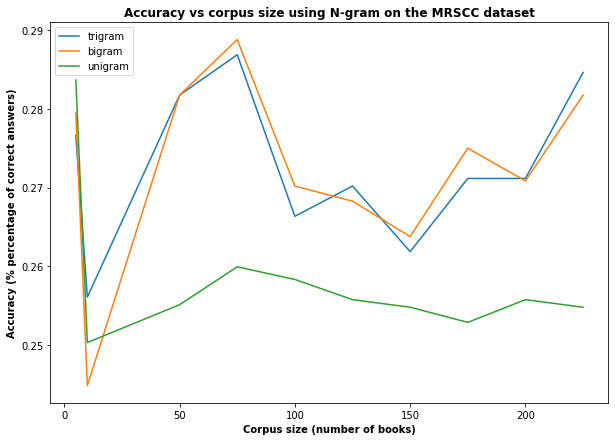

In [129]:
fig = plt.figure(figsize=(10,7))
plt.plot(a_df,label='trigram')
plt.plot(b_df,label='bigram')
plt.plot(c_df,label='unigram')
plt.title("Accuracy vs corpus size using N-gram on the MRSCC dataset",weight="bold")
plt.xlabel('Corpus size (number of books)',weight="bold")
plt.ylabel('Accuracy (% percentage of correct answers)',weight="bold")
plt.legend()
plt.show()

In [25]:
df_a = []
df_b = []
df_c = []
df_a.append(pd.DataFrame(object_file_1).transpose())
df_b.append(pd.DataFrame(object_file_2).transpose())
df_c.append(pd.DataFrame(object_file_1).transpose())

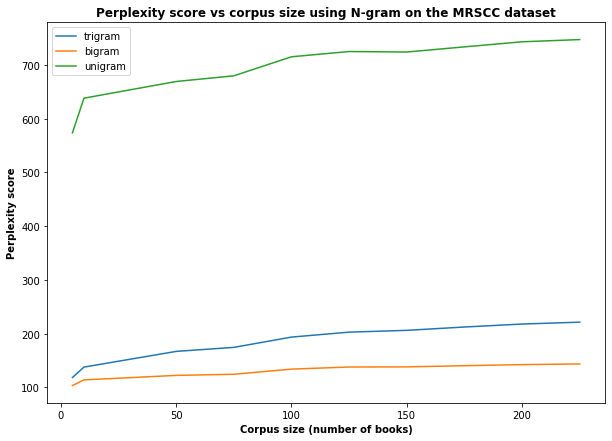

In [128]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


plt.figure(figsize=(10,7))
plt.plot(df_a[0][1],label='trigram')
plt.plot(df_b[0][1],label='bigram')
plt.plot(df_c[0][1],label='unigram')
plt.title("Perplexity score vs corpus size using N-gram on the MRSCC dataset",weight="bold")
plt.xlabel('Corpus size (number of books)',weight="bold")
plt.ylabel('Perplexity score',weight="bold")
plt.legend()
plt.show()